In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import scipy
from scipy import stats
%matplotlib inline

In [2]:
xls = pd.ExcelFile('20180509_Business_Analyst_Case.xlsx')
df = pd.read_excel(xls, 'Data')

In [3]:
df = df.drop(np.arange(7)).reset_index()
df.columns = df.iloc[0]
df = df[1:]
df = df.reset_index().drop(columns = [7, 'index'])
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Customer Orders Data
- **"Customer":** Unique customers who started buying our products in Jan or February 2018
- **"Date Shipped":** Date when orders were fulfilled.  Note that some customers made multiple orders (repeat purchases) while other customers did not.
- **"Product ID":** Unique SKU representing which product was ordered
- **"Brand":**  The customers were buyers of one of 3 brands.  They only purchased from 1 of the 3.
- **"Channel":** How we acquired these customers

# Insight Questions - What keeps customers coming back?
<ol>
    <li> Which brand(s) are stronger and which are weaker at driving repeat purchases? </li>
    <li>Does the marketing channel used to acquire customers make a difference?  </li>
    <li>Are there specific products which are associated with repeat purchases? </li>
    <li>Any other insights that you think would be relevant? </li>
<li>What would be your recommendations around Brand, Product, Marketing to improve repeat purchases?</li>
</ol>

In [95]:
df.head();

## Which brands are stronger/weaker amongst repeat Customers?
- Aggregate level
     - Test Unique Customers
     - Test Particular Time

In [5]:
repeat_df = df[df.duplicated(subset = 'customer') == True]

In [91]:
repeat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6466 entries, 5 to 10642
Data columns (total 5 columns):
customer        6466 non-null object
date_shipped    6466 non-null object
product_id      6466 non-null object
brand           6466 non-null object
channel         6466 non-null object
dtypes: object(5)
memory usage: 303.1+ KB


Considering there were around 10,000 observations in the beginning sample, the number of repeat customers is around 65% of that.

In [7]:
#brand proportion amongst repeat customers
repeat_count = repeat_df.groupby(['brand']).count()['customer']
repeat_prop = repeat_count / repeat_df.shape[0]
repeat_prop

brand
Black Dog      0.205691
Orange Cat     0.106557
White Whale    0.687751
Name: customer, dtype: float64

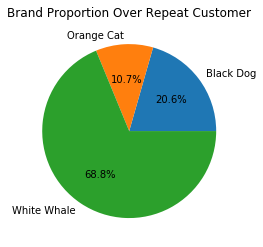

In [8]:
fraction = list(repeat_prop)
label = list(repeat_prop.index)
plt.pie(fraction, labels = label, autopct = '%1.1f%%')
plt.title('Brand Proportion Over Repeat Customer');

From this aggregation of repeat customers, it would seem that White Whale is the most popular choice of Dog Food at nearly 70% of purchases from repeat customers, while Orange Cat and Black Dog occupying the remaining 30%. However, it is uncertain if this could be driven by a particular buyer or by a particular time. For instance, White Whale could be an enormous purchase done by a single individual or supplier which would greatly inflate it's popularity.

### Unique Repeat Customers

In [9]:
#number of repeats from dataset
repeat_df.groupby(['customer']).count()['brand'].describe()

count    3334.000000
mean        1.939412
std         0.756562
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         7.000000
Name: brand, dtype: float64

It would seem that on average the usual number of repeats is around 2, with the maximum of 7. Although it would seem that there are no outrageous outliers in terms of repeat buyers, it may still be useful to check if strictly unique buyers are considered. Unique buyers will be defined by having a unique combination of customer ID and petfood brand as It could be possible that a single user would purchase more than one kind of brand, and therefore qualifying that as a unique purchase.

In [10]:
unique_repeat_df = repeat_df[repeat_df.duplicated(subset = ['customer', 'brand'])]
unique_repeat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3132 entries, 9 to 10642
Data columns (total 5 columns):
customer        3132 non-null object
date_shipped    3132 non-null object
product_id      3132 non-null object
brand           3132 non-null object
channel         3132 non-null object
dtypes: object(5)
memory usage: 146.8+ KB


The number of unique entries is around half the original amount.

In [12]:
unique_repeat_counts = unique_repeat_df.groupby('brand').count()['customer']
unique_repeat_prop = unique_repeat_counts / unique_repeat_df.shape[0]
unique_repeat_prop

brand
Black Dog      0.201149
Orange Cat     0.110153
White Whale    0.688697
Name: customer, dtype: float64

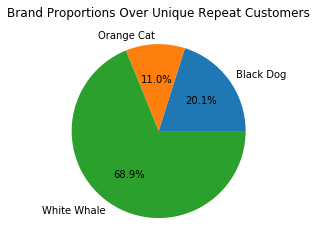

In [13]:
plt.pie(list(unique_repeat_prop), labels = list(unique_repeat_prop.index), autopct = '%1.1f%%')
plt.title('Brand Proportions Over Unique Repeat Customers');

However, even after considering unique purchases, it would seem that the metrics remain relatively unchanged, with Orange Cat, in this sample, increasing by one percent in proportion of purchases and White Whale decreasing by one percent.

### Repeat Customers Graphed Over Time
One possible explanation for the large proportion of White Whale purchases, may be that White Whale purchases were simply purchased in large quantities at a certain point. Perhaps there was a fad that increased sales, or that particular season neccessitated the purchase of a particular good only avaliable at particular brand (for instance, White Whale winter clothes).

In [14]:
time = mdates.drange(repeat_df.date_shipped.min(), 
                      repeat_df.date_shipped.max() + datetime.timedelta(days = 1),
                      datetime.timedelta(days = 1))

In [15]:
black_dog_date = repeat_df.groupby(['brand', 'date_shipped'])['customer'].count()['Black Dog']
orange_cat_date = repeat_df.groupby(['brand', 'date_shipped'])['customer'].count()['Orange Cat']
white_whale_date = repeat_df.groupby(['brand', 'date_shipped'])['customer'].count()['White Whale']

In [16]:
idx = pd.date_range(repeat_df.date_shipped.min(), repeat_df.date_shipped.max())

In [17]:
bd_date1 = black_dog_date.reindex(idx, fill_value = np.nan)
oc_date1 = orange_cat_date.reindex(idx, fill_value = np.nan)
ww_date1 = white_whale_date.reindex(idx, fill_value = np.nan);

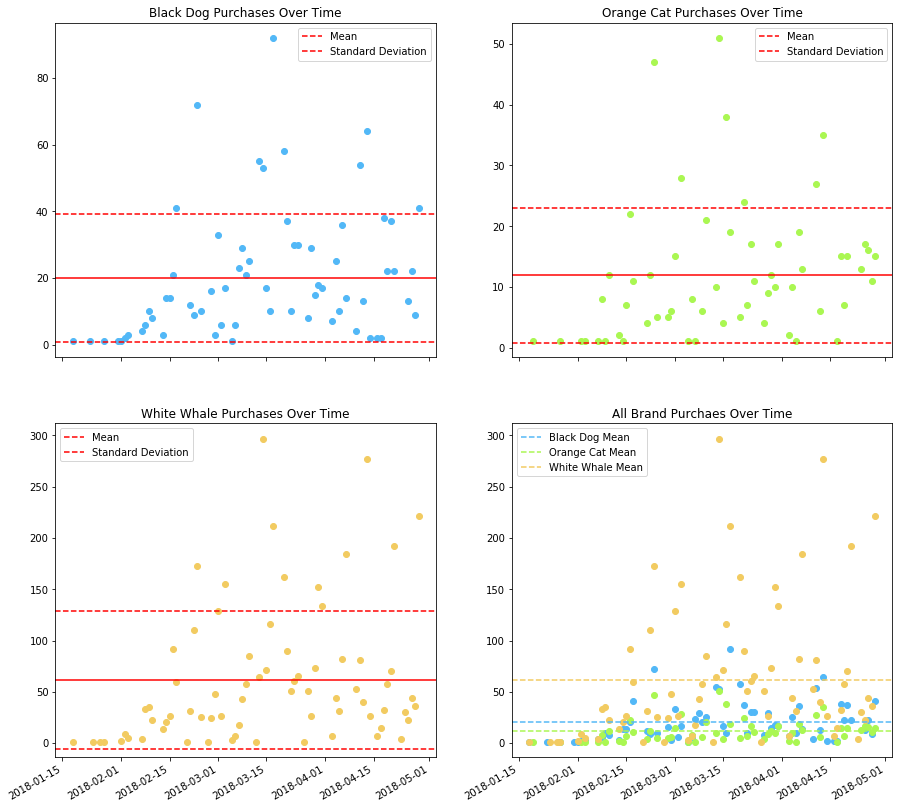

In [149]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15), sharex= True)

#Black Dog
ax1.plot_date(time, bd_date1, c ='#52b8f7')
ax1.set_title('Black Dog Purchases Over Time')
ax1.axhline(np.mean(bd_date1), color = 'r')
ax1.axhline(np.mean(bd_date1) + np.std(bd_date1), color = 'r', ls = '--', label = 'Mean')
ax1.axhline(np.mean(bd_date1) - np.std(bd_date1), color = 'r', ls = '--', label = 'Standard Deviation')
ax1.legend()

ax2.plot_date(time, oc_date1, c= '#aaf752')
ax2.set_title('Orange Cat Purchases Over Time')
ax2.axhline(np.mean(oc_date1), color = 'r')
ax2.axhline(np.mean(oc_date1) + np.std(oc_date1), color = 'r', ls = '--', label = 'Mean')
ax2.axhline(np.mean(oc_date1) - np.std(oc_date1), color = 'r', ls = '--', label = 'Standard Deviation')
ax2.legend()

ax3.plot_date(time, ww_date1, c='#f2cb61')
ax3.set_title('White Whale Purchases Over Time')
ax3.axhline(np.mean(ww_date1), color = 'r')
ax3.axhline(np.mean(ww_date1) + np.std(ww_date1), color = 'r', ls = '--', label = 'Mean')
ax3.axhline(np.mean(ww_date1) - np.std(ww_date1), color = 'r', ls = '--', label = 'Standard Deviation')
ax3.legend()

ax4.plot_date(time, bd_date1, c ='#52b8f7')
ax4.plot_date(time, oc_date1, c= '#aaf752')
ax4.plot_date(time, ww_date1, c='#f2cb61')
ax4.axhline(np.mean(bd_date1), color = '#52b8f7', ls = '--', label = 'Black Dog Mean')
ax4.axhline(np.mean(oc_date1), color = '#aaf752', ls = '--', label = 'Orange Cat Mean')
ax4.axhline(np.mean(ww_date1), color = '#f2cb61', ls = '--', label = 'White Whale Mean')
ax4.set_title('All Brand Purchaes Over Time')
ax4.legend()

f.autofmt_xdate()
plt.show();

From these graphs, it is apparent that there is a fairly large degree of variation in the purchase amounts per day, which indeed suggests that a few outliers in each brand, on days with particularly high sales ("surges"), skew the data of the graph upwards. This phenomenon, regardless of brand, seems to be fairly similar across the board. For instance, a simple count of the number of days above and below the mean demonstrates a gross imbalance; given that a perfectly stable brand would have an relatively even number of sales that were both below and above the mean.

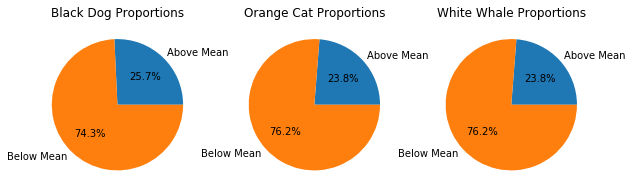

In [141]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,10))

total = bd_date1.shape[0]
num_above = list(bd_date1 > bd_date1.mean()).count(True)
sizes = [num_above/total, (bd_date1.shape[0] - num_above)/total]
sizes
ax1.pie(sizes, labels = ['Above Mean', 'Below Mean'], autopct = '%1.1f%%')
ax1.set_title('Black Dog Proportions')

total = oc_date1.shape[0]
num_above = list(oc_date1 > oc_date1.mean()).count(True)
sizes = [num_above/total, (oc_date1.shape[0] - num_above)/total]
sizes
ax2.pie(sizes, labels = ['Above Mean', 'Below Mean'], autopct = '%1.1f%%')
ax2.set_title('Orange Cat Proportions')

total = ww_date1.shape[0]
num_above = list(ww_date1 > ww_date1.mean()).count(True)
sizes = [num_above/total, (ww_date1.shape[0] - num_above)/total]
sizes
ax3.pie(sizes, labels = ['Above Mean', 'Below Mean'], autopct = '%1.1f%%')
ax3.set_title('White Whale Proportions')

plt.show();

In [89]:
print('The Black dog Skew {}. The Orange Cat skew is {}. The White Whale skew is is {}.'.format((scipy.stats.skew(bd_date1, nan_policy = 'omit')),(scipy.stats.skew(oc_date1, nan_policy = 'omit')), (scipy.stats.skew(ww_date1, nan_policy = 'omit'))                                                     ))

The Black dog Skew 1.4840155591020452. The Orange Cat skew is 1.6099113091148456. The White Whale skew is is 1.607756375601274.


The existance of surge days of relatively similar scale are confirmed by the exceedingly similar amount of skewness between each Brand. Skew greater than 0 suggests weight in the right tail, meaning there are number of observerations that are inflating the mean amount of sales per day. It can be concluded, due to similar skew, that all brands experience surges, and at about the same amount relative to the mean sales per day. However, as noted by the graph above, although the variation and skewness of each Brand is similar, the *scale* is not. This is most apparent in the fourth graph, where each Brands mean is graphed against each other. By far, White Whale has a much higher mean sales per day than either of the other brands, and although such a high mean is inflated due to a number of outliers, it has already been stated that the same amount of inflation exists relative to each Brand.

### Conclusion:
It would seem that the White Whale Brand is the most popular brand amongst repeat customers both across the customer base and intertemporally. When testing the idea that a small subset of repeat customers may be pushing a large number of White Whale orders, thus inflating sales, the proportion of the White Whale Brand customers remained unchanged even after filtering only for unique repeat customers. When testing the idea that a surge purchase of White Whale orders at one point in time had inflated the sales, it was found that such surges do exist, but across all brands. **Overall, White Whale seems to be the profiled brand of a repeat customer.**

## Does the marketing channel used to acquire customers make a difference? 
- Marketing causes brand bias? (continued exploration of previous question)
- Which channel results in more sales?
    - By brand?
        - By product?
- Are certain dates associated with a specific channel?

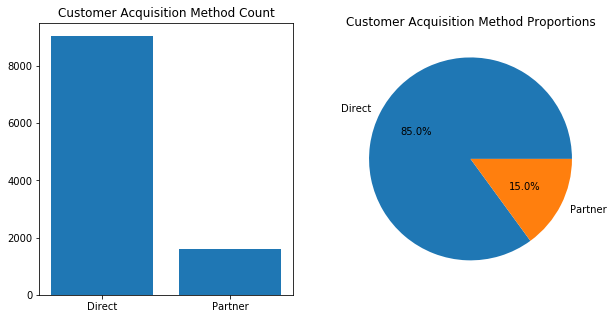

In [140]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

total = df.shape[0]
count = df.groupby('channel').count()['customer'] 
prop = count / total
ax2.pie(prop, labels = prop.index, autopct = '%1.1f%%')
ax2.set_title('Customer Acquisition Method Proportions');

ax1.bar(count.index, count)
ax1.set_title('Customer Acquisition Method Count')
plt.show()

## Product (idea)
It would be really important to investigate product since even if it may seem that white whale is leading in the sales, it could be that only one product is the cause for this, and that more varied goods come from the other two. 